In [2]:
# Imports
import numpy as np
from scipy.stats import norm, skew, uniform
import matplotlib.pyplot as plt

In [70]:
# Valeurs de référence
S0: float = 100
K: float = 100
T: float = 1
r: float = 0.05
sigma: float = 0.2
d: int = 12
N: int = 100000

1. Tracer en fonction de $S_0$ sur un même graphe le prix exact du call européen et le prix
 Monte Carlo de l’option asiatique de mêmes strike et maturité à $d$ dates. Commenter.

In [9]:
def call_price_black_scholes(K, T, S0, r, sigma):
    """
    Works out the price at time 0 of a European call option on the underlying S
    with maturity T and strike K

    INPUTS:
        - K: strike of the option
        - T: maturity of the option
        - S0: price of the underlying asset S at time 0
        - r: risk-free rate
        - sigma: volatility

    OUTPUTS:
        - C0: price of the call option at time 0
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)

    # Computing the call price at time 0
    c0 = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return c0

Pour la simulation de Monte Carlo de l'option asiatique, en reprenant la formule pour le pricing d'une option dépendante de la trajectoire:

$$
\forall i \in [\![1, d]\!], S_{t_i} = S_{t_{i-1}}e^{(r - \frac{\sigma^2}{2}) (t_i - t_{i-1}) + \sigma (B^{\mathbb{Q}}_{t_i} - B^{\mathbb{Q}}_{t_{i-1}})} = S_{t_{i-1}}e^{(r - \frac{\sigma^2}{2}) (t_i - t_{i-1}) + \sigma \sqrt{t_i - t_{i-1}}X_i} 
$$

où $\forall i \in [\![1, d]\!], X_i \hookrightarrow \mathcal{N}(0, 1)$ et sont mutuellements indépendantes (car le mouvement brownien est un processus à accroissements indépendants).

On simplifie le problème en prenant des intervalles de temps réguliers. Ainsi:

$$
t_i - t_{i-1} = \frac{T}{d}
$$

In [131]:
def standard_error(Xs):
    return np.sqrt(np.var(Xs, ddof=1) / len(Xs))

def monte_carlo_discrete_path(N, d, T, S0, r, sigma):
    random_factors = np.exp((r - sigma**2/2)*T/d + sigma * np.random.normal(scale=np.sqrt(T / d), size=(N, d)))
    return S0 * np.cumprod(np.insert(random_factors, 0, 1, axis=1), axis=1)

def MC_est_asian_arith_option(K, T, S0, r, sigma, n, alpha = 0.05):
    payoffs = np.maximum(monte_carlo_discrete_path(N=N, d=n, T=T, S0=S0, r=r, sigma=sigma)[:, 1:].mean(axis=1) - K, 0)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)


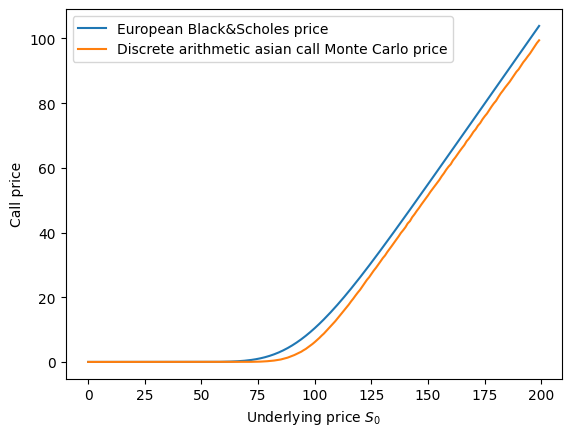

In [124]:
S = np.arange(0.01, 200, 1)
bs_price = [call_price_black_scholes(K, T, s, r, sigma) for s in S]
MC_asian_price = [MC_est_asian_arith_option(K, T, s, r, sigma, d)[0] for s in S]
plt.plot(S, bs_price, label="European Black&Scholes price")
plt.plot(S, MC_asian_price, label="Discrete arithmetic asian call Monte Carlo price" )
plt.xlabel("Underlying price $S_0$")
plt.ylabel("Call price")
plt.legend()
plt.show()

On peut remarquer que le prix du call asiatique est toujours plus bas que celui du call européen. Ceci peut s'expliquer par le fait que les options asiatiques, par la présence de la moyenne, possèdent une volatilité plus faible que les options européenes, ce qui fait diminuer leur prix.

2. Tracer le prix Monte Carlo de l’option asiatique et l’intervalle de confiance associé en fonction du nombre de dates d’observations $d$. Commenter.

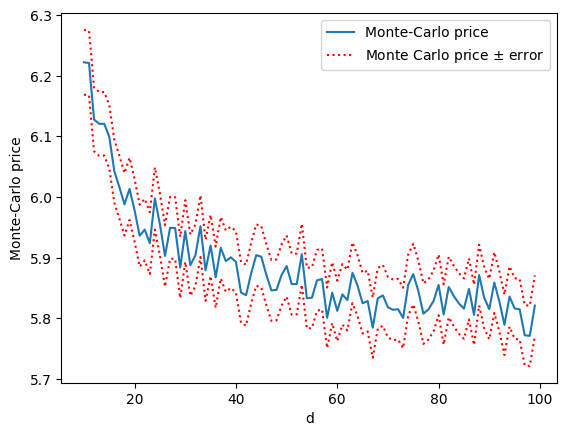

In [133]:
Cns, Cns_up, Cns_down = [], [], []
d_range = [i for i in range(10, 100)]
for n in d_range:
    Cn, error_Cn = MC_est_asian_arith_option(K, T, S0, r, sigma, n)
    Cns.append(Cn)
    Cns_up.append(error_Cn[1])
    Cns_down.append(error_Cn[0])
plt.plot(d_range, Cns, label="Monte-Carlo price")
plt.plot(d_range, Cns_up, linestyle=":", color="red", label="Monte Carlo price $\pm$ error")
plt.plot(d_range, Cns_down, linestyle=":", color="red")
plt.xlabel("d")
plt.ylabel("Monte-Carlo price")
plt.legend()
plt.show()

Le prix fluctue beaucoup pour des petites valeurs de $d$. De plus, la variation du paramêtre $d$ pour $d \ge 20$ n'a aucune influence visible sur la réduction de l'incertitude au niveau de l'estimation du prix, ce qui n'est pas nécessairement surprenant car il s'agit d'un paramêtre du modèle qui ne permet pas de rendre la simulation plus précise comme la variation du paramêtre $N$, ce qui avait été fait lors de la première question.

3. Calculer le prix de Monte-Carlo de l'option asiatique avec la variable de contrôle $Z = S_T$ (que vaut $\mathbb{E}(Z)$?). Vérifier que le prix de Monte Carlo avec la variable de contrôle est correct. Quel est le facteur de réduction de variance obtenu? Estimer par simulation le facteur de réduction théorique. Commenter.

Sous la probabilité risque neutre $\mathbb{Q}$, $S_t = S_0 e^{(r - \frac{\sigma^2}{2})t + \sigma B_{t}^{\mathbb{Q}}}$. Or $(S_0e^{- \frac{\sigma^2}{2}t + \sigma B_{t}^{\mathbb{Q}}})$ est une martingale usuelle car $(B_t^{\mathbb{Q}})$ est un mouvement brownien donc une martingale. Ainsi, dans le cas où $Z = S_T$:

$$
\mathbb{E}(Z) = \mathbb{E}(S_T) = e^{rT}\mathbb{E}(S_0e^{- \frac{\sigma^2}{2}t + \sigma B_{t}^{\mathbb{Q}}}) = e^{rT} S_0
$$

In [127]:
def c_opti(sim_x: np.array, r, T, K):
    """
    """
    # Working out the numerator
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z_vect = sim_x[:, -1]
    z_mean = z_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z_vect - z_mean))
    # Working out the denominator
    denominator = np.sum(np.square(z_vect - z_mean))
    return (- (numerator/denominator), h_vect, z_vect)

sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)
esp_z = np.exp(r * T)* S0
c_star, h_vect, z_vect = c_opti(sim_x, r, T, K)
Cc = np.mean(h_vect + c_star * (z_vect - esp_z))
print(Cc)


6.149789771524869


Le prix obtenu correspond bien à celui obtenu lors de la question précédente. Déterminons le facteur de réduction de variance, exprimé par:

$$
Red_{var} = \frac{\mathbb{V}ar(C_X)}{\mathbb{V}ar(C_{c^*})} =\frac{1}{1 - \rho^2_{(h(X), Z)}}
$$

On peut approcher la corrélation avec les variables simulées

In [126]:
def corr_z_h(sim_x: np.array, K, r, T):
    """
    """
    # Working out the numerator
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z_vect = sim_x[:, -1]
    z_mean = z_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z_vect - z_mean))

    # Working out the denominator
    denominator = np.sqrt(np.sum(np.square(z_vect - z_mean)) * np.sum(np.square(h_vect - h_mean)))

    rho = numerator / denominator
    return rho


# Calul du facteur de réduction
fact_red = 1 / (1 - corr_z_h(sim_x, K, r, T))
print(f"Le facteur de réduction est: {fact_red} pour d=12")

Le facteur de réduction est: 5.516315963351286 pour d=12


On peut tester pour une plage de valeurs de $d$:

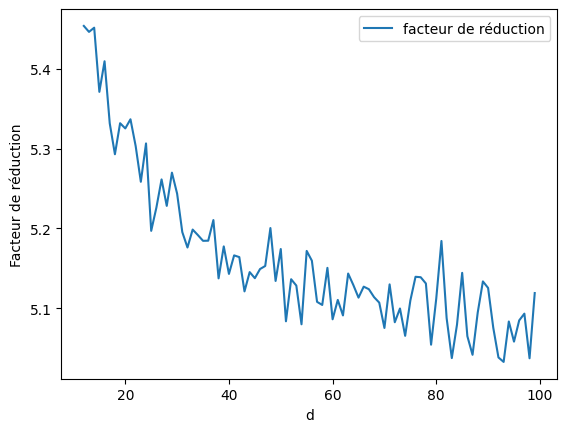

In [128]:
d_range = [i for i in range(12, 100)]
fact_red_list = []
for n in d_range:
    sim_x = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    fact_red = 1 / (1 - corr_z_h(sim_x, K, r, T))
    fact_red_list.append(fact_red)

plt.plot(d_range, fact_red_list, label="facteur de réduction")
plt.xlabel("d")
plt.ylabel("Facteur de réduction")
plt.legend()
plt.show()

Nous voyons que grâce à cette méthode, la variance est réduite par 5 pour un pas de temps donné, ce qui réduit fortement l'intervalle de confiance, et ce même pour les valeurs de $d$ plus élevées. Cependant, celui-ci diminue avec la croissance de $d$.

4. Même question avec $Z = \frac{1}{d} \sum_{i=1}^d S_{t_i}$, puis $Z = e^{-rt}(S_T - K)_{+}$

On traite d'abord le cas où:

$$
Z = \frac{1}{d} \sum_{i=1}^{d}S_{t_i}
$$

On a: 

$$
\mathbb{E}(Z) = \mathbb{E}(\frac{1}{d} \sum_{i=1}^{d} S_{t_i}) = \frac{1}{d} \sum_{i=1}^{d} \mathbb{E}(S_{t_i})
$$

Or:

$$
\forall i \in [\![1, d]\!], \mathbb{E}(S_{t_i}) = e^{r \frac{iT}{d}}\mathbb{E}(S_0e^{\sigma B^{\mathbb{Q}}_{t_i} - \frac{\sigma^2}{2}t_i}) = e^{r \frac{iT}{d}}S_0
$$

par propriété de martingale. Ainsi:

$$
\mathbb{E}(Z) = \frac{S_0}{d}\sum_{i=1}^{d} (e^{\frac{rT}{d}})^i = \frac{S_0}{d}  e^{\frac{rT}{d}} \frac{1 - e^{rT}}{1 - e^{\frac{rT}{d}}}
$$

Calculons le $c^*$ associé et déduisons-en le facteur de réduction.

In [134]:
def c_opti_bis(sim_x: np.array, r, T, K):
    """
    """
    # Working out the numerator
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z_vect = sim_x[:, 1:].mean(axis=1)
    z_mean = z_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z_vect - z_mean))

    # Working out the denominator
    denominator = np.sum(np.square(z_vect - z_mean))
    return (- (numerator/denominator), h_vect, z_vect)
sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)
esp_z = (S0 / d) * np.exp((r * T) / d) * ((1 - np.exp(r * T)) / (1 - np.exp((r * T)/d)))
c_star_bis, h_vect, z_vect = c_opti_bis(sim_x, r, T, K)
Cc_bis = np.mean(h_vect + c_star_bis * (z_vect - (esp_z)))
print(Cc_bis)

# Calcul du facteur de réduction
def corr_z_h_bis(sim_x: np.array, K, r, T):
    """
    """
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z_vect = sim_x.mean(axis=1)
    z_mean = z_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z_vect - z_mean))
    denominator = np.sqrt(np.sum(np.square(z_vect - z_mean)) * np.sum(np.square(h_vect - h_mean)))
    rho = numerator / denominator
    return rho

fact_red_bis = 1 / (1 - corr_z_h_bis(sim_x, K, r, T))
print(f"Le facteur de réduction est: {fact_red_bis} pour d=12")

6.154390831472921
Le facteur de réduction est: 11.557367652431536 pour d=12


On retombe bien sur le prix que l'on avait obtenu à la question 2 pour d=12, cependant, avec cette variable de contrôle, le facteur de réduction est deux fois plus grand que celui considéré juste avant. Ceci est lié au fait que les variables aléatoires $Z$ et $h(X)$ sont beaucoup plus corrélées, car l'on retrouve directement l'expression de Z dans la formule du call asiatique.

Pour le cas où

$$
Z = e^{-rT} (S_T - K)_+
$$

on reconnait le membre dans l'espérance pour l'évaluation d'un call européen. Ainsi, on a la formule explicite suivante pour l'expression de son espérance:

$$
\mathbb{E}(Z) = S_0 \phi(d_1) - K e^{-rT} \phi(d_2)
$$

In [135]:
def c_opti_ter(sim_x: np.array, r, T, K):
    """
    """
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z_vect = np.exp(-r * T) * np.maximum(sim_x[:, -1] - K, 0)
    z_mean = z_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z_vect - z_mean))
    denominator = np.sum(np.square(z_vect - z_mean))
    return (- (numerator/denominator), h_vect, z_vect)

sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)
def call_price_black_scholes(K, T, S0, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    Parameters:
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        float: The Black-Scholes price of the European call option.
    
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

esp_z = call_price_black_scholes(K, T, S0, r, sigma)
c_star_ter, h_vect, z_vect = c_opti_ter(sim_x, r, T, K)
Cc_ter = np.mean(h_vect + c_star_ter * (z_vect - esp_z))
print(Cc_ter)

def corr_z_h_ter(sim_x: np.array, K, r, T):
    """
    """
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z_vect = np.exp(-r * T) * np.maximum(sim_x[:, -1] - K, 0)
    z_mean = z_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z_vect - z_mean))
    denominator = np.sqrt(np.sum(np.square(z_vect - z_mean)) * np.sum(np.square(h_vect - h_mean)))
    rho = numerator / denominator
    return rho

fact_red_ter = 1 / (1 - corr_z_h_ter(sim_x, K, r, T))
print(f"Le facteur de réduction est: {fact_red_ter} pour d=12")

6.151474182819867
Le facteur de réduction est: 7.202788270123316 pour d=12


Ici encore, nous retrouvons bien une valeur cohérente pour l'évaluation de la valeur du call asiatique par rapport aux valeurs trouvées précédemment. Cependant, le facteur de réduction est plus faible que celui considéré précédemment, lié à une plus faible corrélation entre les variables considérées.

5. Même question avec les trois variables simultanément

On commence par calculer la matrice de covariance du vecteur $Z$ et la covariance entre le vecteur $Z$ et $h(X)$

In [136]:
def cov_Z(sim_x: np.array, r, T, K):
    """
    """
    z1 = sim_x[:, -1]
    z2 = sim_x[:, 1:].mean(axis=1)
    z3 = np.exp(-r * T) * np.maximum(sim_x[:, -1] - K, 0)
    z = np.array([z1, z2, z3])
    return np.cov(z), z

def cov_Z_h(sim_x, r, T, K):
    """
    """
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    cov_h_z1 = np.cov(h_vect, sim_x[:, -1])[0, 1]
    cov_h_z2 = np.cov(h_vect, sim_x[:, 1:].mean(axis=1))[0, 1]
    cov_h_z3 = np.cov(h_vect, np.exp(-r * T) * np.maximum(sim_x[:, -1] - K, 0))[0, 1]
    return np.array([[cov_h_z1], [cov_h_z2], [cov_h_z3]]), h_vect

sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)
cov_z, z = cov_Z(sim_x, r, T, K)
cov_z_h, h_vect = cov_Z_h(sim_x, r, T, K)

c_star = np.linalg.solve(cov_z, -cov_z_h)
esp_z = np.array([
    [np.exp(r * T)* S0],
    [(S0 / d) * np.exp((r * T) / d) * ((1 - np.exp(r * T)) / (1 - np.exp((r * T)/d)))],
    [call_price_black_scholes(K, T, S0, r, sigma)]
])

Cc = np.mean(h_vect + c_star * (z - esp_z) )
print(Cc)

# Facteur de réduction
corr = np.dot(cov_z_h.T, np.dot(np.linalg.inv(cov_z), cov_z_h)) / h_vect.var()
fact_red = 1/(1 - corr)
print(f"Le facteur de réduction est: {fact_red[0][0].round(2)} pour d=12")





6.151379973877251
Le facteur de réduction est: 13.72 pour d=12


Encore une fois, on retombre bien sur un valeur pour le prix d'un call asiatique cohérente. De plus, le facteur de réduction est meilleur que l'ensemble de ceux obtenus auparavant, ce qui valide l'utilisation de cette méthode dans ce cas.

6. (*Pour aller plus loin*) Reprendre la question 2 pour une option asiatique à moyenne géométrique et vérifier la convergence vers la valeur exacte.

In [ ]:
# Méthode de Monte-Carlo pour l'évaluation du prix de l'actif

def MC_est_asian_geo_option(K, T, S0, r, sigma, n, alpha = 0.05):
    """
    """
    sim_x = monte_carlo_discrete_path(N=N, d=n, T=T, S0=S0, r=r, sigma=sigma)
    payoffs = np.maximum(np.exp(np.log(sim_x).mean(axis=1)) - S0, 0)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)

MC_est_asian_geo_option(K, T, S0, r, sigma, d)[0]

(np.float64(5.44221089366036), array([5.39547559, 5.4889462 ]))

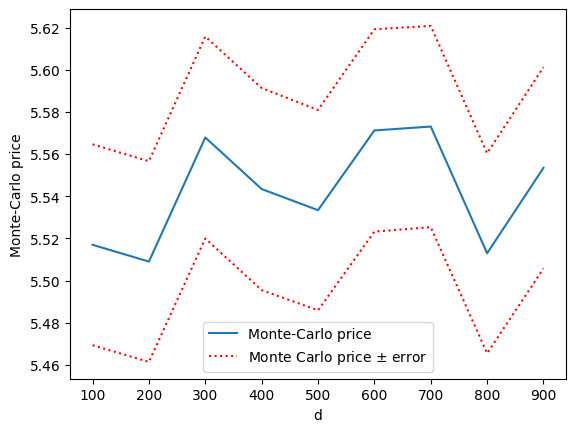

In [147]:
Cns, Cns_up, Cns_down = [], [], []
d_range = [i for i in range(100, 1000, 100)]
for n in d_range:
    Cn, error_Cn = MC_est_asian_geo_option(K, T, S0, r, sigma, n)
    Cns.append(Cn)
    Cns_up.append(error_Cn[1])
    Cns_down.append(error_Cn[0])
plt.plot(d_range, Cns, label="Monte-Carlo price")
plt.plot(d_range, Cns_up, linestyle=":", color="red", label="Monte Carlo price $\pm$ error")
plt.plot(d_range, Cns_down, linestyle=":", color="red")
plt.xlabel("d")
plt.ylabel("Monte-Carlo price")
plt.legend()
plt.show()